# This notebook's aim is to explore the available data and pre-process the text into separate, lemmatized words (removed any stop-words, adjectives and adverbs as well)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Jeremynadal33/categorize_question_API/blob/master/cleaning.ipynb)



First, lets import the needed libraries : 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import re
import time

## My script : 
from function import *

In [2]:
# Specific libraries : 
import nltk
#nltk.download()
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jeremynadal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jeremynadal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/jeremynadal/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
root_dir = '/Users/jeremynadal/Documents/Formation OC IML/P5-API/'
input_dir = root_dir + 'inputs/'
png_dir = root_dir + 'pngs/'

In [44]:
data = pd.read_csv(input_dir+'posts.csv')

print(data.shape)
print(data.dtypes)
data.head()

(50000, 3)
Tags     object
Title    object
Body     object
dtype: object


,Tags,Title,Body
0,<c#><floating-point><type-conversion><double><...,How to convert decimal to double in C#,<p>I want to use a <code>Track-Bar</code> to c...
1,<c#><.net><datetime>,"In C#, how do I calculate someone's age based ...",<p>Given a <code>DateTime</code> representing ...
2,<c#><datetime><time><datediff><relative-time-s...,Calculate relative time in C#,<p>Given a specific <code>DateTime</code> valu...
3,<html><browser><timezone><user-agent><timezone...,Determine a user's timezone,<p>Is there a standard way for a web server to...
4,<.net><math>,Difference between Math.Floor() and Math.Trunc...,"<p>What is the difference between <a href=""htt..."


## Lets get some information about tags
We begin by looking for unique tags 

In [45]:
def handle_tags(tags):
    split = tags.split('><')
    split[0] = split[0][1:]
    split[-1] = split[-1][:-1]
    return split

def get_all_tags(tags):
    res = []
    for i in range(len(tags)):
        for j in range(len(tags[i])):
            res.append(tags[i][j])
            
    return pd.Series(res)

In [46]:
data['Tags'] = data['Tags'].map(handle_tags)

data['nb_tags'] = [len(tags) for tags in data['Tags']]

In [47]:
data.head()

,Tags,Title,Body,nb_tags
0,"[c#, floating-point, type-conversion, double, ...",How to convert decimal to double in C#,<p>I want to use a <code>Track-Bar</code> to c...,5
1,"[c#, .net, datetime]","In C#, how do I calculate someone's age based ...",<p>Given a <code>DateTime</code> representing ...,3
2,"[c#, datetime, time, datediff, relative-time-s...",Calculate relative time in C#,<p>Given a specific <code>DateTime</code> valu...,5
3,"[html, browser, timezone, user-agent, timezone...",Determine a user's timezone,<p>Is there a standard way for a web server to...,5
4,"[.net, math]",Difference between Math.Floor() and Math.Trunc...,"<p>What is the difference between <a href=""htt...",2


In [48]:
tags = get_all_tags(data['Tags'])

In [49]:
tag_counts = pd.Series(tags).value_counts(normalize=True)
tag_counts_cum = np.cumsum(tag_counts)

In [50]:
print('25% of the documents are using {} tags\n50% of the documents are using {} \n75% of the documents are using {}'.format(np.argmin(abs(tag_counts_cum-0.25)),
                                                                    np.argmin(abs(tag_counts_cum-0.5)),
                                                                    np.argmin(abs(tag_counts_cum-0.75))))


25% of the documents are using 10 tags
50% of the documents are using 83 
75% of the documents are using 520


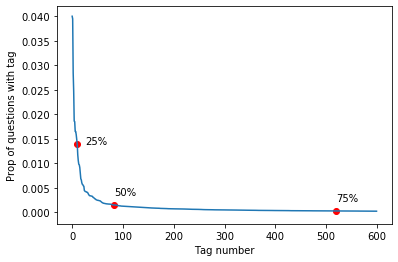

In [51]:
plt.plot(tag_counts.values[:600])
plt.xlabel('Tag number')
plt.ylabel('Prop of questions with tag')
plt.scatter(10,tag_counts[10],c='red')
plt.scatter(83,tag_counts[83],c='red')
plt.scatter(520,tag_counts[520],c='red')
plt.annotate('25%', xy =(10, tag_counts[10]), 
                xytext =(25, tag_counts[10])) 
plt.annotate('50%', xy =(83, tag_counts[83]), 
                xytext =(83, tag_counts[83]+0.002)) 
plt.annotate('75%', xy =(520, tag_counts[520]), 
                xytext =(520, tag_counts[520]+0.002)) 
plt.savefig(png_dir+'cum_sum_tags.png')
plt.show()

Now lets look at how many tags a question has

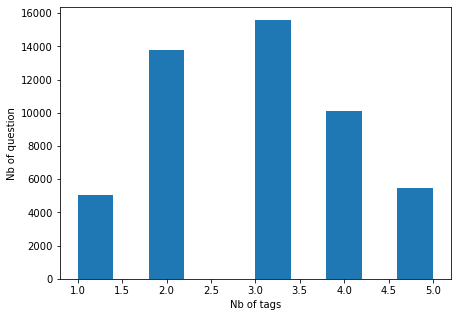

In [52]:
plt.figure(figsize=(7,5))
data['nb_tags'].hist()
plt.grid(None)
plt.ylabel('Nb of question')
plt.xlabel('Nb of tags')
plt.savefig(png_dir+'nb_tags.png')
plt.show()

Lets just look at the top 25 tags

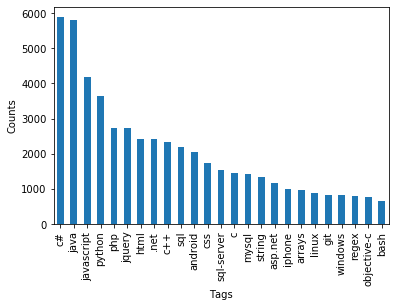

In [13]:
pd.Series(tags).value_counts(normalize=False)[:25].plot(kind = 'bar')
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.savefig(png_dir+'bar_plot_25_tags.png')

## Lets filtrate the data by keeping only the documents corresponding to one of the 25 most common tags

In [14]:
most_common_tags = pd.Series(tags).value_counts(normalize=False)[:25].index
def filter_tags(tags):
    res =  [tag for tag in tags if tag in most_common_tags]
    return (res if res != [] else None)

In [15]:
data['Tags'] = data['Tags'].map(filter_tags)

In [16]:
data.dropna(inplace=True)
data.reset_index(inplace=True, drop = True)
data['nb_tags'] = [len(tags) for tags in data['Tags']]

In [17]:
data

,Tags,Title,Body,nb_tags
0,[c#],How to convert decimal to double in C#,<p>I want to use a <code>Track-Bar</code> to c...,1
1,"[c#, .net]","In C#, how do I calculate someone's age based ...",<p>Given a <code>DateTime</code> representing ...,2
2,[c#],Calculate relative time in C#,<p>Given a specific <code>DateTime</code> valu...,1
3,[html],Determine a user's timezone,<p>Is there a standard way for a web server to...,1
4,[.net],Difference between Math.Floor() and Math.Trunc...,"<p>What is the difference between <a href=""htt...",1
...,...,...,...,...
39404,"[html, css]",Prevent text from overlap table td width,<p>How can I restrict the table <code>&lt;td&g...,2
39405,[android],How to programmatically set the layout_align_p...,<p>I have a relative layout which I am creatin...,1
39406,[bash],How to loop through a directory recursively to...,<p>I need to loop through a directory recursiv...,1
39407,[java],What is the buffer size in BufferedReader?,<p>What is the sense of buffer size in the con...,1


## Now lets begin the preprocessing of the text, the steps are the following : 
* Remove html markings
* Separate text using nltk.word_tokenizer
* Remove unwanted characters
* Remove adjectives, adverbs and digits
* Lematize 
* The processed document is then composed of two times the title and one time the body 

In [18]:
print('For the moment, one question looks like this : \n\n',data['Body'][4])

For the moment, one question looks like this : 

 <p>What is the difference between <a href="http://msdn.microsoft.com/en-us/library/9a6a2sxy.aspx" rel="noreferrer"><code>Math.Floor()</code></a> and <a href="http://msdn.microsoft.com/en-us/library/system.math.truncate.aspx" rel="noreferrer"><code>Math.Truncate()</code></a> in .NET?</p>



In [55]:
pos_from_tag = lambda tag: ('a' if tag[0].lower() == 'j' else tag[0].lower()) if tag[0].lower() in ['n', 'r', 'v'] else 'n'

def handle_body(text, 
                #tokenizer = nltk.RegexpTokenizer(r'\w+'), 
                stop_words = stopwords.words("english"), 
                lemmatizer = WordNetLemmatizer()  ):
    
    POS_to_rm = ['RB','RBR','RBS','JJ','JJR','JJS','CD'] #Removing adverbs and adjectives and digits
    stop_words += ['.','€','$','?','\'s',',',':',';','=','+','-']  
    
    soup = BeautifulSoup(text, 'html.parser')
    tokens = nltk.word_tokenize( soup.get_text().lower() )
    
    tokens = [re.sub('[.,?!)()<>:;\ \"\'\]\[+-=\{\}\|^*@&`’]','',token).replace('\\','').replace('?','') for token in tokens]
    tokens = [token for token in tokens if token != '']
    tags = nltk.pos_tag(tokens)

    tokens = [ tokens[i] for i in range(len(tokens)) if ( (not tokens[i] in stop_words) and (not tags[i][1] in POS_to_rm ) )]
    
    tags = nltk.pos_tag(tokens)
    
    result = [lemmatizer.lemmatize(tokens[i], pos=pos_from_tag(tags[i][1])) for i in range(len(tokens))]
    
    return result 

def handle_title(text,
                 stop_words = stopwords.words("english"), 
                 lemmatizer = WordNetLemmatizer()  ): 
    
    POS_to_rm = ['RB','RBR','RBS','JJ','JJR','JJS'] #Removing adverbs and adjectives
    stop_words += ['.','€','$','?','\'s',',',':',';','=','+','-']  
    
    tokens = re.split(' ', text.lower())
    tokens = [re.sub('[.,?!)()<>:;\ \"\'\]\[+-=\{\}\|^*@&`’]','',token).replace('\\','').replace('?','') for token in tokens]

    tokens = [token for token in tokens if token != '']
    tags = nltk.pos_tag(tokens)
    
    tokens = [ tokens[i] for i in range(len(tokens)) if ( (not tokens[i] in stop_words) and (not tags[i][1] in POS_to_rm ) )]
    
    tags = nltk.pos_tag(tokens)
    
    result = [lemmatizer.lemmatize(tokens[i], pos=pos_from_tag(tags[i][1])) for i in range(len(tokens))]
    
    return result 
    

def handle_row(data):
    documents = []
    
    for i in range(data.shape[0]):
        title = handle_title(data['Title'][i])
        body = handle_body(data['Body'][i])
        doc = title + title + body
        documents.append(doc)
        
    return documents

In [56]:
documents = handle_row(data)

In [57]:
data['processed_text'] = documents

/Users/jeremynadal/anaconda3/envs/fieldbox/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [58]:
print('One document is then described as follows : \n\n',data['processed_text'][0])

One document is then described as follows : 

 ['convert', 'double', 'c#', 'convert', 'double', 'c#', 'want', 'use', 'trackbar', 'change', 'form', 'opacity', 'code', 'trans', 'thisopacity', 'trans', 'build', 'application', 'give', 'error', 'type', 'decimal', 'double', 'try', 'use', 'trans', 'control', 'work', 'code', 'work', 'vbnet', 'project']


In [30]:
data_to_save = data[['Tags','processed_text','nb_tags']]
data_to_save

,Tags,processed_text,nb_tags
0,[c#],"[convert, double, c#, convert, double, c#, wan...",1
1,"[c#, .net]","[c#, calculate, someone, age, base, datetime, ...",2
2,[c#],"[calculate, time, c#, calculate, time, c#, giv...",1
3,[html],"[determine, user, timezone, determine, user, t...",1
4,[.net],"[difference, mathfloor, mathtruncate, differen...",1
...,...,...,...
39404,"[html, css]","[prevent, text, td, width, prevent, text, td, ...",2
39405,[android],"[set, attribute, button, layout, set, attribut...",1
39406,[bash],"[loop, directory, delete, file, extension, loo...",1
39407,[java],"[buffer, size, bufferedreader, buffer, size, b...",1


In [31]:
data_to_save.to_csv(input_dir+'processed_dataset.csv', index = False)